In [ ]:
# mount your GDrive, where the .ipynb and the .csv files are
from google.colab import drive
drive.mount('/content/drive')

# **Data Mining Techniques (Ex 1) | Customer personality analysis**
#--------------------------------------------------------------------------------------------------------



### Question 1: Dataset preprocessing
The following actions were performed during data preprocessing:

- Assignment of the ID column as the index of the dataframe. This is useful for faster and more efficient record lookups based on the ID.
- Deletion of records that contain at least one empty value.
- Conversion of the Dt_Customer column to a Datetime object with the format (DAY-MONTH-YEAR).
- Creation and application of mappings between text and numerical values for the Education and Marital_Status columns.

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/My Drive/marketing_campaign.csv", delimiter="\t")
df.dropna(axis=0, inplace=True)

# Change to Datetime object
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format="%d-%m-%Y")

# Convert Marital status values to integers
Marital_Status_map = {status: num for num, status in enumerate(df['Marital_Status'].unique())}
df['Marital_Status'] = df['Marital_Status'].map(Marital_Status_map)

# Convert Education values to integers
Education_map = {education: num for num,
                      education in enumerate(df['Education'].unique())}
df['Education'] = df['Education'].map(Education_map)
df

### Question 2: Count for unique values of Marital Status and Education
Initially, for the data in the Marital_Status column, we replace the values "Absurd," "Alone," and "YOLO" with the value "Single." Then, a chart is created that displays the count of individuals for each category (unique value of Marital_Status). Finally, we assign the labels of the column values to the chart based on the mapping structure between text and numbers. We follow the same process for the Education column chart as well.

In [ ]:
import seaborn as sns

# Replace dataframe unique values Absurd, Alone, YOLO with Single
df['Marital_Status'] = df['Marital_Status'].replace([Marital_Status_map['Absurd'], Marital_Status_map['Alone'], Marital_Status_map['YOLO']], Marital_Status_map['Single'])
Marital_Status_map = {status: key for status, key in Marital_Status_map.items() if status not in ['Alone', 'Absurd', 'YOLO']} # update map
plot_status = sns.countplot(x='Marital_Status', data=df)

# Set labels for marital status based on str values instead of integers
unique_statuses = [status for status in Marital_Status_map]
plot_status.set_xticklabels(unique_statuses);

In [ ]:
plot_edu = sns.countplot(x='Education', data=df)

# Set labels for Education based on str values instead of integers
unique_edu = [edu for edu in Education_map]
plot_edu.set_xticklabels(unique_edu);

### Question 3: Create new columns
The creation of new columns in the dataframe is performed through a simple assignment using the format df['x'] = expr, where 'x' is the name of the column, and the assignment is applied for each row of the column. If we want to apply some if-else logic to each data in the column, we use the .apply() method on the dataframe, passing a reference to a function as an argument.

In [ ]:
# A Customer For
curr_day = pd.Timestamp(pd.Timestamp.now().strftime('%Y-%m-%d'))
df['Customer_For'] = (curr_day - pd.to_timedelta(df['Recency'], unit='day')) - df['Dt_Customer']

# B Age
curr_year = pd.Timestamp.now().year
df['Age'] = curr_year - df['Year_Birth']

# C Spent
df['Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# D Children
df['Children'] = df['Kidhome'] + df['Teenhome']

# E Family Size
def parents(x):
    if x == Marital_Status_map['Married'] or x == Marital_Status_map['Together']:
        return 2
    else:
        return 1
df['Family_Size'] = df['Children'] + df['Marital_Status'].apply(lambda x: parents(x))

# F Is_Parent
def Is_Parent(x):
    if x == Marital_Status_map['Single'] or x == Marital_Status_map['Together']:
        return 0
    else:
        return 1
df['Is_Parent'] = df['Marital_Status'].apply(lambda x: Is_Parent(x))

# G Living_With
def status(x):
    if x == Marital_Status_map['Married'] or x == Marital_Status_map['Together']:
        return 'Partner'
    else:
        return 'Alone'
df['Living_With'] = df['Marital_Status'].apply(lambda x: status(x))

# H Age Group
def age_group(age):
    if age >= 21 and age <= 30:
        return '21-30'
    elif age >= 31 and age <= 40:
        return '31-40'
    elif age >= 41 and age <= 50:
        return '41-50'
    elif age >= 51 and age <= 60:
        return '51-60'
    elif age >= 61 and age <= 70:
        return '61-70'
    elif age >= 71 and age <= 80:
        return '71-80'
    else:
        return '80-...'
df['Age_Group'] = df['Age'].apply(lambda age: age_group(age))
df

### Question 4: Remove outliers
To remove outliers from the data, we selected the Age, Income, and Spent columns as they are more important for our data analysis. We set an acceptable limit of standard deviation for all the data. After calculating the standard deviation for each data point in the dataframe relative to the others belonging to the same column, those exceeding the limit are removed. The value of 3 was chosen as the absolute threshold because we observed that it only removes values that significantly differ from the rest, avoiding inconsistencies in subsequent analysis. For example, it removes age values above 100.

In [ ]:
from scipy import stats

zscore_limit = 3 # limit

# Age outliers
age_zscores = stats.zscore(df['Age'])
df = df.loc[abs(age_zscores) <= zscore_limit]

# Income
income_zscores = stats.zscore(df['Income'])
df = df.loc[abs(income_zscores) <= zscore_limit]

# Spent
spent_zscores = stats.zscore(df['Spent'])
df = df[abs(spent_zscores) <= zscore_limit]

df

### Question 5: Heatmap to find characteristics correlations
In the following heatmap chart, we observe the correlation between the data in each column of the dataframe with the data in the other columns. The correlation between two columns is represented by a number ranging from -1 to 1. If the number is positive, it indicates that as it increases, the correlation also increases, meaning that the data in the respective columns tend to increase or decrease at a similar rate. If we have a negative correlation, it means that as the values of one column increase, the values of the other column tend to decrease.

In [ ]:
import matplotlib.pyplot as plt
df_heatmap = df[['Age', 'Spent', 'Income', 'Family_Size', 'Children', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']]
sns.heatmap(df_heatmap.corr(), annot=False, cmap='coolwarm');

### Question 6: Plots

- Countplot: It shows the count for each unique value of a column.
- Boxplot: It displays the relationship between data from different columns by finding the median (line), the minimum and maximum values (top and bottom lines), how spread out the data is in the upper and lower quartiles, as well as any values considered outliers (diamonds). It is important to note that the outliers shown in the diagrams do not negatively affect our analysis, so we did not further restrict our data.
- Histogram: It shows the count for each value in the column of interest. If there are many values (e.g., Income), then the values are grouped together.

In [ ]:
# 2 x 5 grid of plots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))

# 2. Number of customers that have complained
complain_plot = sns.countplot(x='Complain', data=df.loc[df['Complain'] == 1], ax=axs[0, 0])
complain_plot.set_ylabel('Customers')
complain_plot.set_xticklabels(['Complained'])

# 3. Marital status and Spent
Spent_Marital_plot = sns.boxplot(x='Marital_Status', y='Spent', data=df, ax=axs[0, 1])
Spent_Marital_plot.set_xticklabels(unique_statuses)

# 4. Family_Size and Spent
sns.boxplot(x='Family_Size', y='Spent', data=df, ax=axs[1, 0])

# 7. Education and Income
Edu_Income_plot = sns.boxplot(x='Education', y='Income', data=df, ax=axs[1, 1])
Edu_Income_plot.set_xticklabels(unique_edu)

# 8. Family_Size and Income
sns.boxplot(x='Family_Size', y='Income', data=df, ax=axs[2, 0])

# 9. Children and Income
sns.boxplot(x='Children', y='Income', data=df, ax=axs[2, 1])

# 10. Living With and Income
sns.boxplot(x='Living_With', y='Income', data=df, ax=axs[3, 0])

# 12. Number of web purhcases and number of visits per month
sns.boxplot(x='NumWebPurchases', y='NumWebVisitsMonth', data=df, ax=axs[3, 1])

# 14. NumDealsPurchases
sns.histplot(data=df, x='NumDealsPurchases', ax=axs[4, 0])

# 15. histogram Income
sns.histplot(data=df, x='Income', ax=axs[4, 1])

# adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# show the plot
plt.show()

### Question 7: LabelEncoder() following 'One Hot Encoding' logic
The LabelEncoder() is a library that converts categorical variables (generally non-numerical data) into numerical values. For example, in the real world, a person has a gender of male/female. The LabelEncoder() reads such data and converts them into numerical values (e.g., male=0, female=1, and so on). It recognizes how many different unique values of a categorical variable appear in the data and maps them to values from 0 to "number of unique different values - 1". The use of LabelEncoder() is done at this stage, before applying the StandardScaler(), because the latter needs to accept numerical values to normalize them.


In [ ]:
# Importing SciKit Learn packages
from sklearn.preprocessing import LabelEncoder

# Education
# Initialize 'Education' unique values set
education_data = {'Education': ['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle']}

# Use LabelEncoder to convert category values to numerical values and create a new column in the DataFrame
label_encoder = LabelEncoder()
df['Education'] = label_encoder.fit_transform(df['Education'])

# Marital_Status
# Initialize 'Marital_Status' unique values set
marital_status_data = {'Marital_Status': ['Single', 'Together', 'Married', 'Divorced', 'Widow']}

# Use LabelEncoder to convert category values to numerical values and create a new column in the DataFrame
df['Marital_Status'] = label_encoder.fit_transform(df['Marital_Status'])

# Living_With
# Initialize 'Living_With' unique values set
education_data = {'Living_With': ['Alone', 'Partner']}

# Use LabelEncoder to convert category values to numerical values and create a new column in the DataFrame
df['Living_With'] = label_encoder.fit_transform(df['Living_With'])

df

In [ ]:
# making a copy of the current DataFrame (df)
df_copy = df.copy()

# deleting columns related to promoting and special offers
df_copy = df_copy.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response'], axis=1)

df_copy

The StandardScaler() by default normalizes the data so that its distribution has a mean (μ) of 0 and a standard deviation (σ) of 1 in each column.

In [ ]:
from sklearn.preprocessing import StandardScaler

# function to convert an 'Age Group' (age range) string into numerical value
def convert_age_range(age_range):

    age_range = age_range.split('-')
    age = (int(age_range[0]) / 10) + 1
    return age

# convert Timestamp values into numerical values
df_copy['Dt_Customer'] = df_copy['Dt_Customer'].apply(lambda x: x.timestamp() if isinstance(x, pd.Timestamp) else x)

# convert Timedelta values into numerical values
df_copy['Customer_For'] = df_copy['Customer_For'].apply(lambda x: x.days if isinstance(x, pd.Timedelta) else x)

# convert 'Age_Group' values form strings into numerical values
# for example, range '51-60' is converted into '6', because '51-60' range represents the 6th decade of a human's life
df_copy['Age_Group'] = df_copy['Age_Group'].apply(convert_age_range)

# create an instance of the StandardScaler object
scaler = StandardScaler()

# fit and standardize the DataFrame (df_copy), after the numerical conversions we made
df_standardized = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)

df_standardized

In [ ]:
# processing the new DataFrame (df_standardized) using PCA

# import the PCA module
from sklearn.decomposition import PCA


# define number of dimensions (= components) we want our data to be reduced to
pca = PCA(n_components=3)
pca.fit(df_standardized)
pca_components = pca.transform(df_standardized)

df_PCA = pd.DataFrame(pca_components, columns=['PCA_1', 'PCA_2', 'PCA_3'])

The 3D plot is interactive, allowing better visualization and understanding of the results. It provides features such as mouse drag and zooming to explore the plot from different angles and perspectives.

In [ ]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# Define the data for the 3D scatter plot
data = go.Scatter3d(x=df_PCA['PCA_1'], y=df_PCA['PCA_2'], z=df_PCA['PCA_3'], mode='markers', marker=dict(size=4, color='red', opacity=0.8))

# Define the layout for the plot
layout = go.Layout(title='3D Plot of PCA components', width=800, height=800, margin=dict(l=0, r=0, t=50, b=0), scene=dict(xaxis_title='PCA_1', yaxis_title='PCA_2', zaxis_title='PCA_3'))

# Combine the data and layout into a figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()

### Question 8: Clustering

* The ELBOW algorithm is applied to normalized data, so we need to use the normalized version of our .csv file, which is the df_standardized dataframe. The ELBOW method calculates the optimal number of clusters to apply to a dataset for the best representation/correlation of the data. We input a range of values equal to the different numbers of clusters we want to test in order to find the most suitable one for our dataset. The algorithm calculates the SSE (Sum of Squared Errors), which is the sum of the squared errors as a function of the number of clusters each time. Thus, a function is defined, which in turn is represented by a correlation diagram of 'SSE-num of clusters'.

* For example, in the following diagram, we initially observe that as we consider more clusters, the SSE decreases (which is expected because the more cluster centroids we have, the fewer data points will be far away from the centroids, resulting in smaller SSE terms). After a certain number of clusters, the change in SSE is not significant. Conversely, if we choose to have fewer clusters (i.e., cluster centroids), more distant data points will appear (larger square errors), resulting in an overall increase in SSE.

* In order to find the optimal number of clusters, we check at which point of the diagram (at what number of clusters) the SSE starts to increase rapidly (in our example, this happens for #clusters=3 or 4). This is the point/region that forms an "elbow," which is why it is called the ELBOW method.

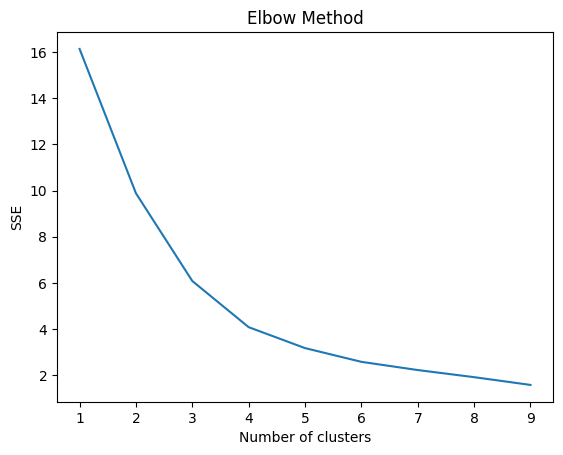

In [ ]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')   # suppressing non-vital warnings regarding the change of value of some variables

# Determine the optimal #clusters using the ELBOW method
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df_standardized)
    sse.append(kmeans.inertia_)

# Plot the SSE for each k
plt.plot(range(1, 15), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('ELBOW method diagram')
plt.show()


Indeed, we can observe that for #clusters < 4, the SSE starts to increase rapidly. Therefore, we consider the "elbow" point to be at #clusters = 4.

* The Agglomerative and Kmeans algorithms are applied to normalized data, so we need to use the normalized version of our .csv file. Additionally, to have a better cluster visualization, we use the reduced version of our data (the one with PCA_1, PCA_2, and PCA_3), which is the df_PCA dataframe. The logic behind Agglomerative is that it gradually tries to create a hierarchical structure of correlations among the data, eventually constructing a single cluster with all the data points. On the other hand, Kmeans follows a partitioning logic, where after determining the number of clusters, the algorithm assigns each data point to the nearest cluster centroid. The centroids can be adjusted to achieve optimal assignment and clustering of the data points. The process is repeated until the centroids practically do not change, and there is a "balance" in the system/structure of the clusters.

* The silhouette score is a metric used to evaluate the similarity of a data point to its assigned cluster, indicating the quality of the clustering we have chosen. Its value ranges from -1 to 1. A score of -1 indicates minimal similarity to the assigned cluster, while a score of 1 indicates maximum/"perfect" similarity. When the score is 0, it means that the data point is on the boundary between two clusters (i.e., it is equally similar to both).

* In brief, the silhouette score is obtained by calculating the average distance of the data point to the other points within its cluster (intra-cluster distance), the average distance to the data points of the neighboring clusters (nearest-cluster distance), and then finding the score for each data point using these two distances and taking the maximum of them. After calculating the scores for all data points, the overall mean is calculated to characterize the quality of our clustering.

The 3D plot is interactive for better visualization and comprehension of the results (mouse drag and zooming). Additionally, we observe that there are no cluster centroids in Agglomerative clustering since it does not employ such a centroid-based approach for cluster computation.

In [ ]:
import plotly.graph_objs as go
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

# Perform Agglomerative clustering
agglom = AgglomerativeClustering(n_clusters=4)  # 4 clusters as we calculated previously
agglom_labels = agglom.fit_predict(df_PCA)

# Add cluster labels to original dataset
df_PCA['Cluster'] = agglom_labels

# Create a trace for each cluster
traces = []
for i in range(4):
    trace = go.Scatter3d(
        x=df_PCA.loc[df_PCA['Cluster'] == i]['PCA_1'],
        y=df_PCA.loc[df_PCA['Cluster'] == i]['PCA_2'],
        z=df_PCA.loc[df_PCA['Cluster'] == i]['PCA_3'],
        mode='markers',
        marker=dict(
            size=4,
            color=i,  # assign a different color to each cluster
            opacity=0.8
        ),
        name=f'Cluster {i}'
    )
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title='Agglomerative 3D plot',
    scene=dict(
        xaxis_title='PCA_1',
        yaxis_title='PCA_2',
        zaxis_title='PCA_3'
    ),
    width=800,  # set the width of the plot
    height=800  # set the height of the plot
)

# Create the figure object
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()


If we simply want to visualize the hierarchical tree structure created by Agglomerative clustering, we can execute the following code on our standardized dataset (df_standardized), assuming that we are working with the entire dataset and not the reduced 3-dimensional version:

In [ ]:
# Create linkage matrix
tree = linkage(df_standardized, method='ward')

# Create dendrogram with truncated branches
plt.figure(figsize=(30, 12))
dendrogram(tree, color_threshold=10)
plt.title('Agglomerative tree plot')
plt.show()

# Create dendrogram with truncated branches (ZOOMED in)
plt.figure(figsize=(30, 12))
dendrogram(tree, color_threshold=10, truncate_mode='lastp', p=200)
plt.title('Agglomerative tree plot (ZOOMED in)')
plt.show()

In the following code segment, we create the data clusters using the K-means algorithm. The 3D plot is interactive, allowing for better visualization and understanding of the results through mouse drag and zooming. On the right side of the plot, there is a filter box where we can select or unselect a specific color representing a cluster. This allows us to temporarily "hide" a cluster from the plot.

In [ ]:
import plotly.graph_objs as go

# Prepare the data for clustering
data = df_PCA[['PCA_1', 'PCA_2', 'PCA_3']].values
n_clusters = 4

# Initialize the KMeans algorithm, #clusters=4 as we found previously
kmeans = KMeans(n_clusters)

# Fit the algorithm to the data
kmeans.fit(data)

# Get cluster labels for each data point
labels = kmeans.predict(data)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Define the color map for the clusters
colors = ['red', 'green', 'blue', 'yellow']

# Create a 3D scatter plot with different colors for each cluster
fig = go.Figure()
for i in range(n_clusters):
    x = data[labels == i][:, 0]
    y = data[labels == i][:, 1]
    z = data[labels == i][:, 2]
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color=colors[i], size=3)))

# Add the cluster centers to the plot
fig.add_trace(go.Scatter3d(x=centers[:, 0], y=centers[:, 1], z=centers[:, 2], mode='markers', marker=dict(color='black', size=6)))

# Set the labels for the axes
fig.update_layout(scene=dict(xaxis_title='PCA_1', yaxis_title='PCA_2', zaxis_title='PCA_3'), width=1000, height=800, autosize=False, margin=dict(l=50, r=50, b=50, t=50))

# Enable mouse interactions for rotating the plot
fig.update_layout(scene_camera=dict(eye=dict(x=1.7, y=-0.6, z=0.8)))

# Show the plot
fig.show()
